In [ ]:
"""
# load Tmean Tsig in GDEM
# calculate Tavg in GDEM to compare with 1T
# plot GDEM T distribution, Tmean, Tavg, T_1T, 
# note cstat/dof at upper left of the plot
"""

In [2]:
import matplotlib.pyplot as plt

def basic_figure_style():
    SMALL_SIZE = 5*4                                       
    MEDIUM_SIZE = 8*2
    BIGGER_SIZE = 10*4

    plt.rc('font', size=MEDIUM_SIZE, family='serif')          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)                     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE, direction='out')    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE, direction='out')    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)                    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
    plt.rc('lines', linewidth=1) 
    plt.rc('axes', grid=True) #
    plt.rc('grid', alpha=0.7) #
    plt.rc('xtick', top=True)
    plt.rc('ytick', right=True)
    plt.rc('axes.formatter', use_mathtext=True, min_exponent=4, useoffset=False)
    plt.rc('figure', figsize='6, 6')                         # size of the figure, used to be '4, 3' in inches

    # Set LaTeX rendering to True
    plt.rc('text', usetex=False)

basic_figure_style()


In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import os
from glob import glob
import pandas as pd
from tqdm import tqdm
from scipy.stats import norm

1 plot all

In [4]:
# calculate Tavg in GDEM to compare with 1T
def gaussian(x, mean, std_dev):
    value = np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))
    return value/np.sum(value)
    
def cal_gadem_Tavg(x, gauss):
    fil = x>0
    return np.sum(x[fil] * gauss[fil])/np.sum(gauss[fil])

In [9]:
# load Tmean Tsig in GDEM

#### set paths ####
rootdir = f'/Users/eusracenorth/Documents/work/XGAP-ABUN/alldata'
savepath = f'{rootdir}/figs/T_distribution'
datapath = f'{rootdir}/dats'
os.makedirs(f'{savepath}', exist_ok=True)

#### load data ####
file_1T = f'{datapath}/R500-01_1T_xspec.csv'
file_GD = f'{datapath}/R500-01_GDEM_xspec.csv'
df_1T = pd.read_csv(file_1T)
df_GD = pd.read_csv(file_GD)

Tavg_dict = {'ID':[], 'Tavg':[], 'Tavg_lo':[], 'Tavg_hi':[]}
#### plot ####
# GDEM T distribution
for i in tqdm(range(len(df_GD))):
    fig,ax = plt.subplots(figsize = (8,8))
    xarr = np.linspace(1e-2, 20, 10000)
    Tmean = df_GD['T-value'][i]
    Tmean_lo = df_GD['T-value'][i] - df_GD['T-errlo'][i]
    Tmean_hi = df_GD['T-value'][i] + df_GD['T-errhi'][i]
    Tsig = df_GD['Tsig-value'][i]
    Tsig_lo = df_GD['Tsig-value'][i] - df_GD['Tsig-errlo'][i]
    Tsig_hi = df_GD['Tsig-value'][i] + df_GD['Tsig-errhi'][i]
    Tdist = gaussian(xarr, Tmean, Tsig)
    Tdist_lo = gaussian(xarr, Tmean_lo, Tsig_lo)
    Tdist_hi = gaussian(xarr, Tmean_hi, Tsig_hi)


    T1 = df_1T['T-value'][i]
    T1_lo = df_1T['T-value'][i] - df_1T['T-errlo'][i]
    T1_hi = df_1T['T-value'][i] + df_1T['T-errhi'][i]


    # Cal Tavg
    Tavg = cal_gadem_Tavg(xarr, Tdist)
    Tavg_lo = cal_gadem_Tavg(xarr, Tdist_lo)
    Tavg_hi = cal_gadem_Tavg(xarr, Tdist_hi)
    Tavg_dict['ID'].append(df_1T["reg"][i])
    Tavg_dict['Tavg'].append(Tavg)
    Tavg_dict['Tavg_lo'].append(Tavg_lo)
    Tavg_dict['Tavg_hi'].append(Tavg_hi)

    plt.plot(xarr, Tdist, color= 'r', label = 'GDEM')
    # plt.fill_between(xarr, y1 = Tdist_lo, y2 = Tdist_hi, color= 'r', alpha = 0.3)

    plt.axvline(Tavg, color = 'r', label = 'Tavg')
    plt.fill_betweenx(np.linspace(0,1,2), Tavg_lo, Tavg_hi,  color = 'r', alpha = 0.3)

    # plt.axvline(Tmean, color = 'k', label = 'Tmean')
    # plt.fill_betweeny(Tmean_lo, Tmean_hi, color = 'k', alpha = 0.3)

    plt.axvline(T1, color = 'b', label = 'T_1T')
    plt.fill_betweenx(np.linspace(0,1,2),T1_lo, T1_hi, color = 'b', alpha = 0.3)

    plt.xlabel('T [keV]')
    # plt.ylabel('normalized EM')
    plt.ylabel('PDF')
    plt.title(f"{df_1T['reg'][i]}")
    # stat_1t = np.round(df_1T["cstat"][i]/df_1T["dof"][i], decimals=2)
    # stat_gd = np.round(df_GD["cstat"][i]/df_GD["dof"][i], decimals=2)
    plt.text(0,1, f'cstat/d.o.f \n 1T: {np.round(df_1T["cstat"][i], decimals = 1)}/{np.round(df_1T["dof"][i], decimals = 1)}\n GDEM: {np.round(df_GD["cstat"][i], decimals = 1)}/{np.round(df_GD["dof"][i], decimals= 1)}',
         bbox=dict(facecolor='white', alpha=0.5),horizontalalignment='left',
     verticalalignment='top', transform=ax.transAxes)
    plt.ylim(0,2*np.max(Tdist))
    plt.xlim(xarr[Tdist>1e-4][0],xarr[Tdist>1e-4][-1])
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{savepath}/{df_1T["reg"][i]}.png')
    plt.close()

df = pd.DataFrame(Tavg_dict)
df.to_csv(f'{datapath}/GDEM_Tavg_xspec.csv')

100%|██████████| 44/44 [00:05<00:00,  7.99it/s]


2 select cstat of GDEM comparable or smaller than 1T, plot in one

In [12]:
# load Tmean Tsig in GDEM

#### set paths ####
rootdir = f'/Users/eusracenorth/Documents/work/XGAP-ABUN/alldata'
savepath = f'{rootdir}/figs/T_distribution'
datapath = f'{rootdir}/dats'
os.makedirs(f'{savepath}', exist_ok=True)

#### load data ####
file_1T = f'{datapath}/R500-01_1T_xspec.csv'
file_GD = f'{datapath}/R500-01_GDEM_xspec.csv'
df_1T = pd.read_csv(file_1T)
df_GD = pd.read_csv(file_GD)
print(df_1T['reg'][~np.isin(df_1T['reg'], df_GD['reg'])])
#### plot ####
# confirm indexes
stat_1t = np.round(df_1T["cstat"]/df_1T["dof"], decimals=2)
stat_gd = np.round(df_GD["cstat"]/df_GD["dof"], decimals=2)

# crit_dict = {'close_cstat':abs(stat_gd-stat_1t)<0.3, 'gdem_better':(stat_gd-stat_1t)<0, 'gdem_worse':(stat_gd-stat_1t)>0}

# fil = crit_dict['close_cstat']
# num_figs = np.sum(fil)
# idxs = np.arange(len(stat_1t))[fil]


idxs = np.arange(len(stat_1t))

print(len(idxs))
print(np.sum(stat_gd - stat_1t<0))
print(df_GD['T-value'])
Tavg_lst = []
# plot
fig, axs = plt.subplots(int(len(idxs)//5+1), 5, figsize = (30,45))
for j, i in enumerate(idxs):
    xarr = np.linspace(1e-2, 20, 10000)
    Tmean = df_GD['T-value'][i]
    Tmean_lo = df_GD['T-value'][i] - df_GD['T-errlo'][i]
    Tmean_hi = df_GD['T-value'][i] + df_GD['T-errhi'][i]
    Tsig = df_GD['Tsig-value'][i]
    Tsig_lo = df_GD['Tsig-value'][i] - df_GD['Tsig-errlo'][i]
    Tsig_hi = df_GD['Tsig-value'][i] + df_GD['Tsig-errhi'][i]
    Tdist = gaussian(xarr, Tmean, Tsig)
    Tdist_lo = gaussian(xarr, Tmean_lo, Tsig_lo)
    Tdist_hi = gaussian(xarr, Tmean_hi, Tsig_hi)


    T1 = df_1T['T-value'][i]
    T1_lo = df_1T['T-value'][i] - df_1T['T-errlo'][i]
    T1_hi = df_1T['T-value'][i] + df_1T['T-errhi'][i]


    # Cal Tavg
    Tavg = cal_gadem_Tavg(xarr, Tdist)
    Tavg_lo = cal_gadem_Tavg(xarr, Tdist_lo)
    Tavg_hi = cal_gadem_Tavg(xarr, Tdist_hi)

    Tavg_lst.append(Tavg)
    
    axs[j//axs.shape[1], j%axs.shape[1]].plot(xarr, Tdist, color= 'r', label = 'GDEM')
    # axs[j//axs.shape[1], j%axs.shape[1]].fill_between(xarr, y1 = Tdist_lo, y2 = Tdist_hi, color= 'r', alpha = 0.3)

    axs[j//axs.shape[1], j%axs.shape[1]].axvline(Tavg, color = 'r', label = 'Tavg')
    axs[j//axs.shape[1], j%axs.shape[1]].fill_betweenx(np.linspace(0,1,2), Tavg_lo, Tavg_hi,  color = 'r', alpha = 0.3)

    # axs[j//axs.shape[1], j%axs.shape[1]].axvline(Tmean, color = 'k', label = 'Tmean')
    # axs[j//axs.shape[1], j%axs.shape[1]].fill_betweeny(Tmean_lo, Tmean_hi, color = 'k', alpha = 0.3)

    axs[j//axs.shape[1], j%axs.shape[1]].axvline(T1, color = 'b', label = 'T_1T')
    axs[j//axs.shape[1], j%axs.shape[1]].fill_betweenx(np.linspace(0,1,2),T1_lo, T1_hi, color = 'b', alpha = 0.3)

    axs[j//axs.shape[1], j%axs.shape[1]].set_xlabel('T [keV]')
    axs[j//axs.shape[1], j%axs.shape[1]].set_ylabel('pdf')
    axs[j//axs.shape[1], j%axs.shape[1]].set_title(f"{df_1T['reg'][i]}")
    stat_1t = np.round(df_1T["cstat"][i]/df_1T["dof"][i], decimals=2)
    stat_gd = np.round(df_GD["cstat"][i]/df_GD["dof"][i], decimals=2)
    
    axs[j//axs.shape[1], j%axs.shape[1]].set_ylim(0,2*np.max(Tdist))
    axs[j//axs.shape[1], j%axs.shape[1]].set_xlim(xarr[Tdist>1e-4][0],xarr[Tdist>1e-4][-1])
    axs[j//axs.shape[1], j%axs.shape[1]].legend()
    if stat_1t < stat_gd:
        axs[j//axs.shape[1], j%axs.shape[1]].text(0,1, f'cstat/d.o.f \n 1T: {stat_1t}\n GDEM: {stat_gd}',
        bbox=dict(facecolor='blue', alpha=0.3),horizontalalignment='left',
    verticalalignment='top', transform=axs[j // axs.shape[1], j % axs.shape[1]].transAxes)
    else:
        axs[j//axs.shape[1], j%axs.shape[1]].text(0,1, f'cstat/d.o.f \n 1T: {stat_1t}\n GDEM: {stat_gd}',
        bbox=dict(facecolor='red', alpha=0.3),horizontalalignment='left',
    verticalalignment='top', transform=axs[j // axs.shape[1], j % axs.shape[1]].transAxes)

plt.subplots_adjust(top=0.9)  # Adjust the top parameter as needed
# plt.suptitle(f'fitting has close cstat {num_figs}, where gdem better: {np.sum(crit_dict["gdem_better"])}, gdem worse: {np.sum(crit_dict["gdem_worse"])}', fontsize = 16, y = 0.98)
plt.tight_layout()
plt.savefig(f'{savepath}/Tdist_all.png')
plt.close()
    

Series([], Name: reg, dtype: object)
44
33
0      0.922195
1      3.886560
2      0.850750
3      0.565004
4      0.995525
5      0.010000
6      1.300990
7      1.544470
8      0.618656
9      3.542010
10     1.068280
11     1.932730
12     1.630630
13     2.539550
14     3.334990
15     0.378389
16     2.065590
17     1.652060
18     0.051479
19     1.388210
20     2.133020
21    10.388200
22     3.488830
23     1.330790
24     0.010000
25     2.810980
26     7.699310
27     6.129990
28     0.989132
29     4.076010
30     2.710970
31     0.802445
32     1.348850
33     0.951306
34     0.778462
35     0.637700
36     0.822176
37     0.384632
38     0.086452
39     1.954270
40     2.713060
41     3.012340
42     1.114610
43     1.690060
Name: T-value, dtype: float64


3 group the groups according to Tavg

44
35    SDSSTG21128
Name: reg, dtype: object


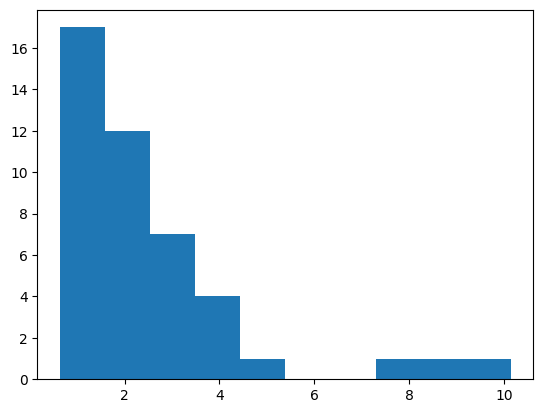

In [32]:
Tavgs = np.array(Tavg_lst)
print(len(Tavgs))
plt.hist(Tavgs)
print(df_1T['reg'][(Tavgs>0) &(Tavgs<0.7)])


4 see the T variance distribution